# The Flowers Dataset

$\textbf{About the Dataset}$

 The dataset contains 3670 raw jpeg images of five types of flowers:
- daisy
- dandelion
- rose
- sunflower
- tulip


In the associated folder one will find five folders namely - 'daisy', 'dandelion', 'rose', 'sunflower' and 'tulip' which contain the images of the respective flowers. In this notebook our goal will be to build a neural network from scratch, and then finetune it to improve the model.

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16
from keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
from google.colab import files

# Exploring the dataset

We start by loading the data from our Drive folder:

In [2]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Mounted at /content/gdrive


In [3]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['roses', 'sunflowers', 'tulips', 'daisy', 'dandelion']


See the distribution of images sizes:

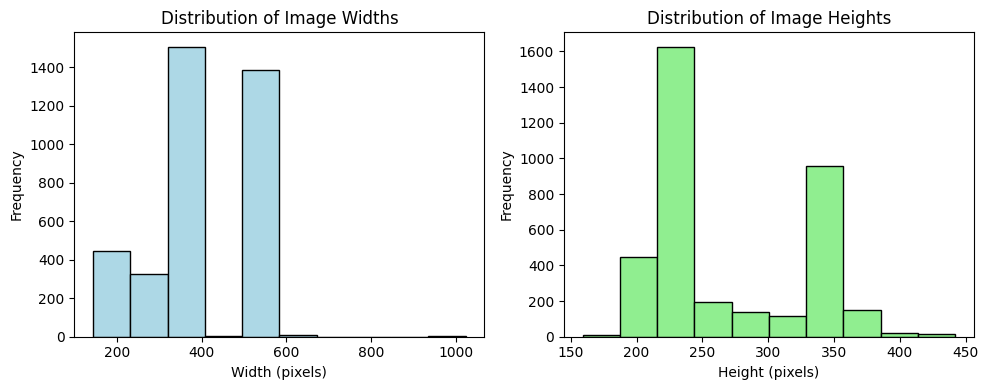

In [4]:
# Function to get image sizes
def get_image_sizes(folder_path):
    widths = []
    heights = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    return widths, heights

# Get image sizes
widths, heights = get_image_sizes('flower_photos')

# Visualize the distribution of image sizes
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=10, color='lightblue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Checking the image sizes before resizing them to a standard size like 224x224 pixels can be important for several reasons:

1) Data Quality Assessment:

- Anomalies: Detecting images that may have unusual dimensions (e.g., extremely small or large images) can indicate potential data quality issues.
- Consistency: Ensuring that the majority of images are within a reasonable range of sizes can confirm the dataset's overall consistency.

2) Aspect Ratio Preservation:

- Distortion: If images have widely varying aspect ratios, resizing them to a fixed size can distort the images, which may affect model performance. Understanding the aspect ratios can help you decide whether to crop or pad images to maintain aspect ratios.
Resource Planning:

- Memory Usage: Larger images consume more memory and computational resources. Knowing the distribution of image sizes can help in planning the computational resources needed for processing and training.
Preprocessing Strategy:

- Informed Decisions: Insights from the size distribution can guide decisions on preprocessing techniques, such as whether to use resizing, cropping, padding, or other transformations.

Let's see how the classes are distributed:

Labels distribution:
Class: roses , Count: 641 , Perc :17.5%
Class: sunflowers , Count: 699 , Perc :19.0%
Class: tulips , Count: 799 , Perc :21.8%
Class: daisy , Count: 633 , Perc :17.2%
Class: dandelion , Count: 898 , Perc :24.5%


<ipython-input-5-6c79791ebbdc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=class_counts, palette=palette)


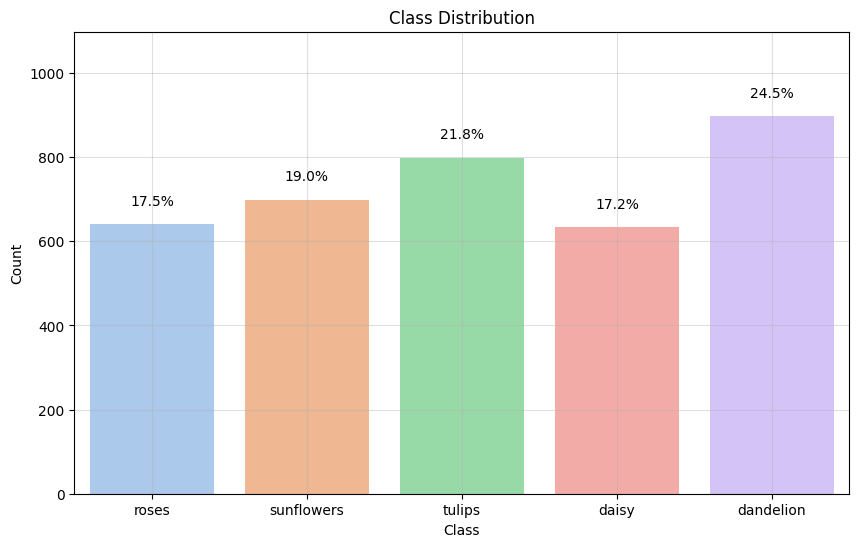

In [5]:
# Data exploration
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(5):
    print('Class:', class_names[i], ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

palette = sns.color_palette("pastel", len(unique_classes))

plt.figure(figsize=(10, 6))
sns.barplot(x=unique_classes, y=class_counts, palette=palette)

for i, count in enumerate(class_counts):
    percentage = 100 * count / len(y)
    plt.text(i, count + 0.05 * max(class_counts), f'{percentage:.1f}%', ha='center')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes, class_names)
plt.grid(True, alpha=0.4)
plt.ylim(0, max(class_counts) + 200)  # Adjusting y-axis limit to add some space for annotations

#plt.savefig("classes-distribution.png")
#files.download("classes-distribution.png")
plt.show()

We see they are almost evenly distributed, so we will first try to train the neural network without data augmentation. Then, we will augment the data and see if this helps in improving the model.

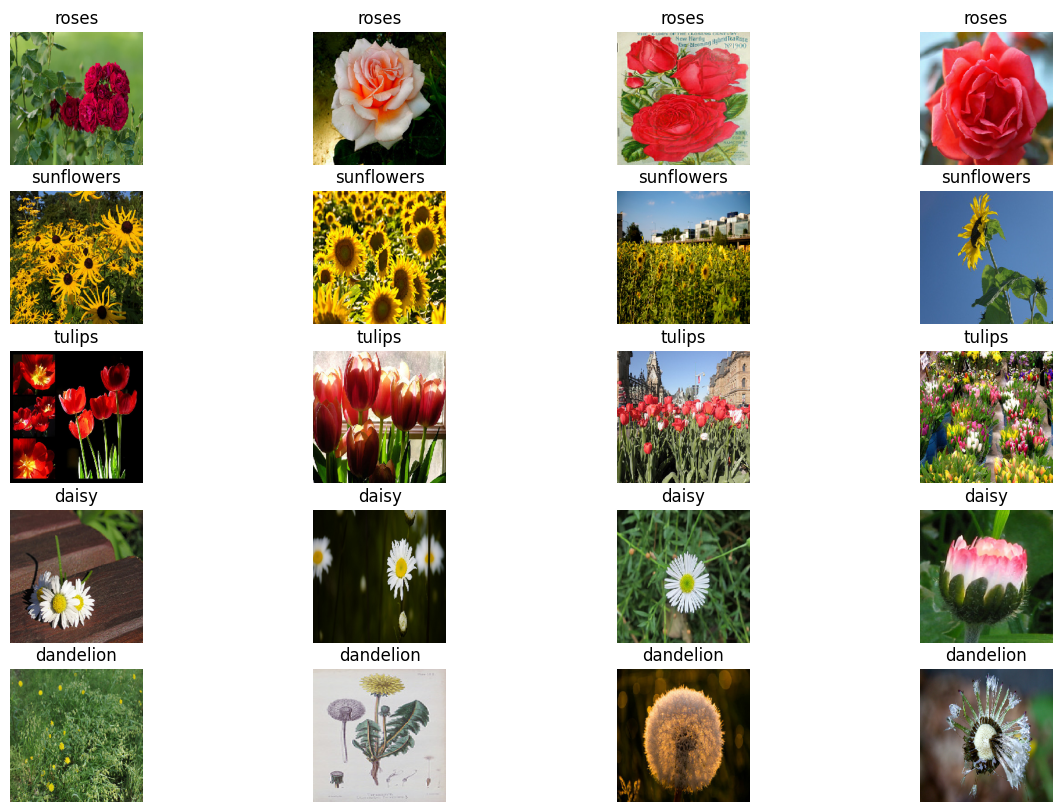

In [6]:
# Function to display sample images

def display_sample_images(X, y, class_names, samples_per_class=4):
    plt.figure(figsize=(15, 10))
    for cls_idx, class_name in enumerate(class_names):
        idxs = np.where(y == cls_idx)[0]
        selected_idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(selected_idxs):
            plt.subplot(len(class_names), samples_per_class, cls_idx * samples_per_class + i + 1)
            plt.imshow(X[idx].astype("uint8"))
            plt.title(class_name)
            plt.axis('off')
    plt.show()

# Display few samples
display_sample_images(X, y, class_names)

# Preprocessing

We normalize the dataset, and provide the augmentation using the module $\texttt{keras.layers.experimental.preprocessing}$.

In [7]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

Normalizing image data by dividing by 255 is a common practice because pixel values in typical images are represented as integers in the range [0, 255]. This range corresponds to an 8-bit representation of pixel intensities, where 0 represents black and 255 represents white in grayscale images.

In [8]:
# Normalize data first:

X_normalized = X/255.

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [10]:
# Delete unused data, to prevent RAM from going boom

del(X)
del(X_normalized)

In [11]:
# Sequence of modules to place before the actual NN

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Neural Network

## Without data augmentation

In [12]:
model = keras.models.Sequential([

    keras.layers.Input(shape=(224, 224, 3)),

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

In [13]:
# for the moment fix LR and epochs

lr = 0.001
epochs = 30
n_classes = 5

In [14]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)       

In [16]:
# Encode classes in valid format

y_train_encoded = to_categorical(y_train, n_classes)
y_val_encoded = to_categorical(y_val, n_classes)

# Include if you want to stop when not improving anymore
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [17]:
# Fit the model

history = model.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/30
92/92 [==============================] - 13s 47ms/step - loss: 1.4002 - accuracy: 0.3627 - val_loss: 1.2071 - val_accuracy: 0.4932
Epoch 2/30
92/92 [==============================] - 3s 31ms/step - loss: 1.1067 - accuracy: 0.5276 - val_loss: 1.1229 - val_accuracy: 0.4796
Epoch 3/30
92/92 [==============================] - 3s 32ms/step - loss: 1.0088 - accuracy: 0.5763 - val_loss: 0.9394 - val_accuracy: 0.5940
Epoch 4/30
92/92 [==============================] - 3s 36ms/step - loss: 0.9087 - accuracy: 0.6267 - val_loss: 0.8656 - val_accuracy: 0.6458
Epoch 5/30
92/92 [==============================] - 3s 31ms/step - loss: 0.8719 - accuracy: 0.6540 - val_loss: 0.8858 - val_accuracy: 0.6349
Epoch 6/30
92/92 [==============================] - 3s 32ms/step - loss: 0.8019 - accuracy: 0.6717 - val_loss: 0.8388 - val_accuracy: 0.6485
Epoch 7/30
92/92 [==============================] - 3s 31ms/step - loss: 0.7570 - accuracy: 0.6986 - val_loss: 0.7883 - val_accuracy: 0.7003
Epoch 8/30
9

In [18]:
# Save the model to Google Drive
model_save_path = '/content/drive/My Drive/Colab Notebooks/flower_classification_NOAUG_model.h5'
model.save(model_save_path)

# Load the model from Google Drive
model_load_path = '/content/drive/My Drive/Colab Notebooks/flower_classification_NOAUG_model.h5'
loaded_model = tf.keras.models.load_model(model_load_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## With data augmentation

In [19]:
model_aug = keras.models.Sequential([

    data_augmentation, # insert prior to any operation

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

In [20]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model_aug.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
# Print model summary
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)       

In [22]:
# Fit the model

history = model_aug.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/30
92/92 [==============================] - 7s 38ms/step - loss: 1.4570 - accuracy: 0.3692 - val_loss: 1.3046 - val_accuracy: 0.4087
Epoch 2/30
92/92 [==============================] - 3s 33ms/step - loss: 1.2061 - accuracy: 0.4656 - val_loss: 1.1979 - val_accuracy: 0.4714
Epoch 3/30
92/92 [==============================] - 3s 35ms/step - loss: 1.0864 - accuracy: 0.5490 - val_loss: 1.0658 - val_accuracy: 0.5313
Epoch 4/30
92/92 [==============================] - 3s 38ms/step - loss: 1.0092 - accuracy: 0.5743 - val_loss: 0.9859 - val_accuracy: 0.5804
Epoch 5/30
92/92 [==============================] - 3s 33ms/step - loss: 0.9667 - accuracy: 0.6161 - val_loss: 0.9551 - val_accuracy: 0.5831
Epoch 6/30
92/92 [==============================] - 3s 34ms/step - loss: 0.9091 - accuracy: 0.6277 - val_loss: 1.0076 - val_accuracy: 0.6267
Epoch 7/30
92/92 [==============================] - 3s 32ms/step - loss: 0.8712 - accuracy: 0.6492 - val_loss: 0.7838 - val_accuracy: 0.6894
Epoch 8/30
92

In [23]:
# Save the model to Google Drive
model_save_path = '/content/drive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
model_aug.save(model_save_path)

# Load the model from Google Drive
model_load_path = '/content/drive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
loaded_model_aug = tf.keras.models.load_model(model_load_path)

In [24]:
# see other notebook for the analysis